In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import shutil
from time import time
import torch
from copy import copy
from glob import glob
from PIL import Image, ImageFile
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import recgn_utils # utility script 

In [2]:
# Verifica se CUDA está disponível 
gpu_on = torch.cuda.is_available()

if not gpu_on:
    print('Use a CPU. CUDA não está disponível...')
else:
    print('Use a GPU. CUDA está disponível...')

Use a GPU. CUDA está disponível...


In [3]:
# Configure alguns parametros:

# Path raiz do dataset 
rcgn_dir = '../input/dog-breed-recognition-v3/dogs/recognition'

# Numero de classes a serem selecionadas para enroll (de 1 a 20)
num_classes_enroll = 5

# Numero medio de imagens selecionadas para enroll, em cada classe 
num_img_enroll = 11

# Total de imagens utilizadas no enroll
total_img_enroll = num_classes_enroll * num_img_enroll

# Tamanho do dataset
batch_size = num_classes_enroll #TBC

# Numero de workers
num_workers = 0

# Numero de epocas
num_epochs = 25

# Metadados e Modelo treinado com fine-tune, na Parte-1 
checkpoint_path = "../input/modelp1v9ep15nllloss/model_epoch_15_acc_84.4318_loss_0.5199.pth"

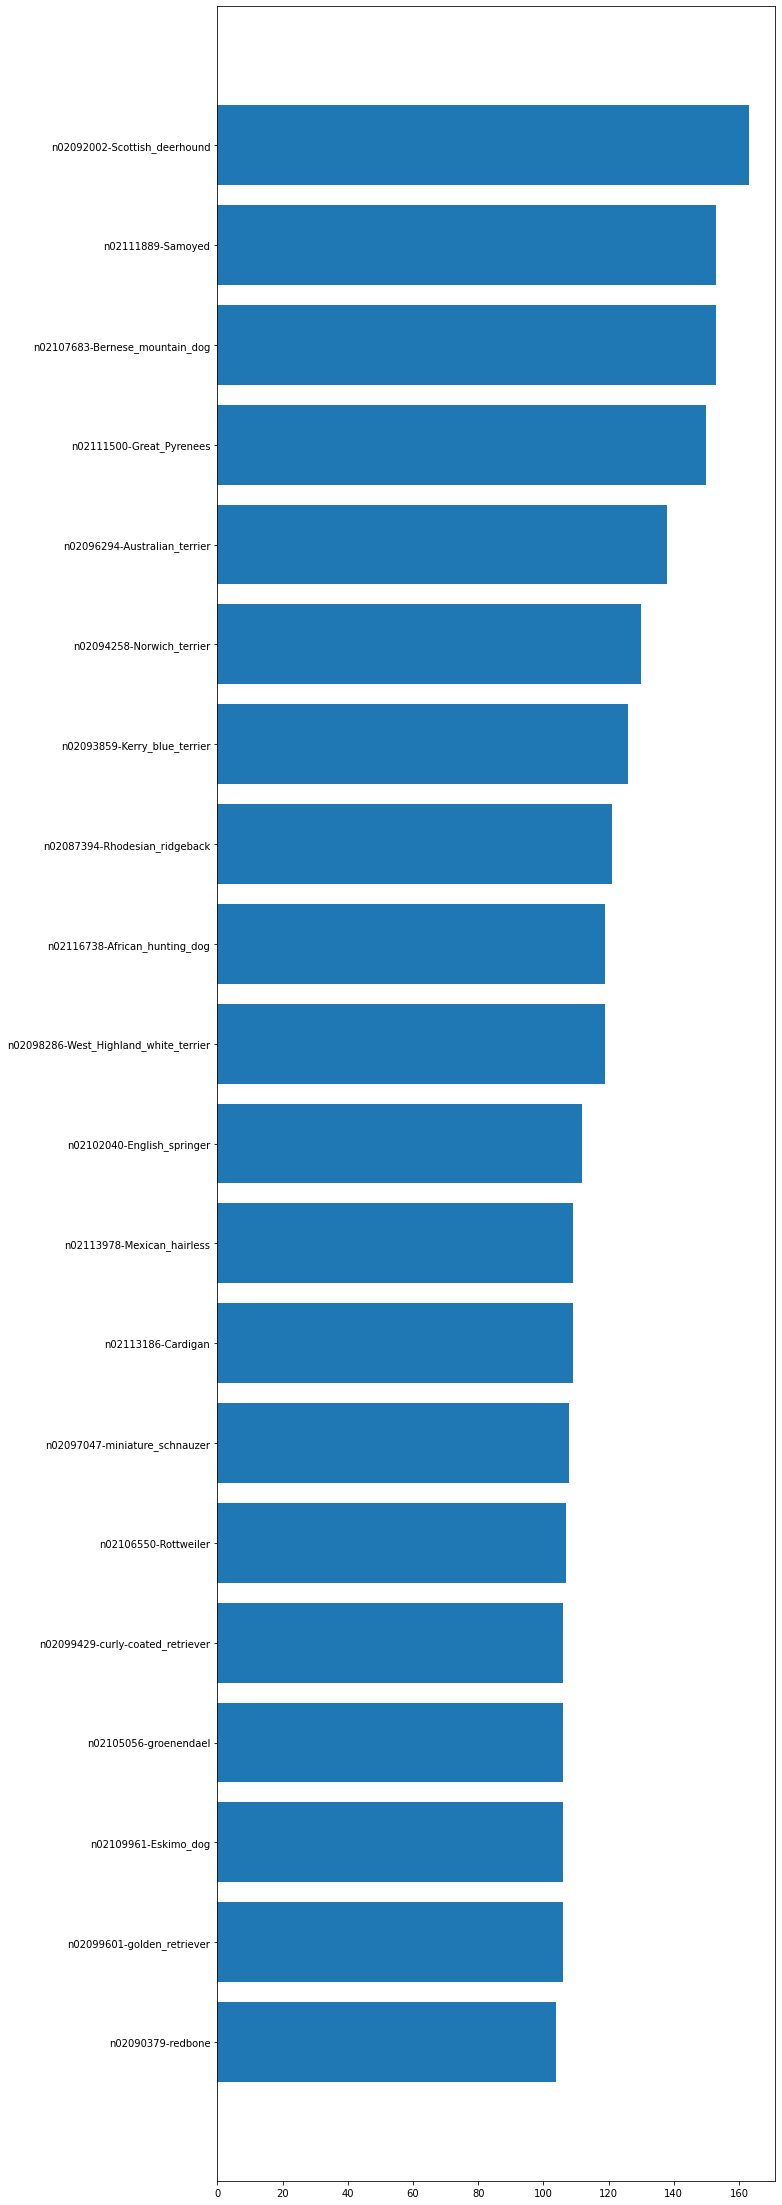

In [4]:
# Paths contendo imagens originais para treino e teste
data_dir = rcgn_dir + '/enroll'
test_dir = rcgn_dir + '/test'

# Plota quantidade ordenada de imagens por classe, para verficar se estao desbalanceadas
_, _ = recgn_utils.check_class(data_dir)

In [5]:
# Lista nomes de todas as classes
full_class_names = [item.split('/')[-2] for item in sorted(glob(data_dir + "/*/"))]
print(f'> Lista das classes disponiveis para enroll = {full_class_names}\n')

# Seleciona subset de classes para enroll, e.g. classes de 1 a 5
partial_class_names = full_class_names[0:num_classes_enroll]  
print(f'> Lista das classes selecionadas para enroll = {partial_class_names}')

> Lista das classes disponiveis para enroll = ['n02087394-Rhodesian_ridgeback', 'n02090379-redbone', 'n02092002-Scottish_deerhound', 'n02093859-Kerry_blue_terrier', 'n02094258-Norwich_terrier', 'n02096294-Australian_terrier', 'n02097047-miniature_schnauzer', 'n02098286-West_Highland_white_terrier', 'n02099429-curly-coated_retriever', 'n02099601-golden_retriever', 'n02102040-English_springer', 'n02105056-groenendael', 'n02106550-Rottweiler', 'n02107683-Bernese_mountain_dog', 'n02109961-Eskimo_dog', 'n02111500-Great_Pyrenees', 'n02111889-Samoyed', 'n02113186-Cardigan', 'n02113978-Mexican_hairless', 'n02116738-African_hunting_dog']

> Lista das classes selecionadas para enroll = ['n02087394-Rhodesian_ridgeback', 'n02090379-redbone', 'n02092002-Scottish_deerhound', 'n02093859-Kerry_blue_terrier', 'n02094258-Norwich_terrier']


In [6]:
# Seleciona as classes para treinamento/validacao no enroll
# Copia arquivos apenas das classes selecionadas
def sel_class(class_names, from_path, to_path):
    print(f'Copiando {len(class_names)} classes de {from_path}/enroll/ para {to_path}/enroll/')
    print(f'Copiando {len(class_names)} classes de {from_path}/test/ para {to_path}/test/')
    for name in class_names:
        old_path_train = (from_path + '/enroll/' + name)
        old_path_test = (from_path + '/test/' + name)
        new_path_train = (to_path + '/enroll/' + name)
        new_path_test = (to_path + '/test/' + name)
        shutil.copytree(old_path_train, new_path_train)
        shutil.copytree(old_path_test, new_path_test)

In [7]:
# Define diretorios para transferencia de imagens
new_rcgn_dir = '/kaggle/working/rcgn_sample'

# Esvazia diretorio de destino (i.e. apaga e recria)
!rm -rf {new_rcgn_dir}
!mkdir {new_rcgn_dir}

# Realiza transferencia das classes selecionadas, para novo diretorio de desino
from_path = rcgn_dir
to_path = new_rcgn_dir
sel_class(partial_class_names, from_path, to_path)

# Lista novo diretorio de imagens
!ls {new_rcgn_dir}

Copiando 5 classes de ../input/dog-breed-recognition-v3/dogs/recognition/enroll/ para /kaggle/working/rcgn_sample/enroll/
Copiando 5 classes de ../input/dog-breed-recognition-v3/dogs/recognition/test/ para /kaggle/working/rcgn_sample/test/
enroll	test


In [8]:
# NOVOS paths contendo imagens para treino (enroll) e teste
data_dir = new_rcgn_dir + '/enroll'
test_dir = new_rcgn_dir + '/test'

# Lista nomes das classes selecionadas
partial_class_names = [item.split('/')[-2] for item in sorted(glob(data_dir + "/*/"))]
print(f'> Lista das classes selecionadas para enroll = {partial_class_names}\n')

# Calcula numero de classes
num_classes_enroll = len(partial_class_names)
print(f'> Numero de classes selecionadas = {num_classes_enroll}')

> Lista das classes selecionadas para enroll = ['n02087394-Rhodesian_ridgeback', 'n02090379-redbone', 'n02092002-Scottish_deerhound', 'n02093859-Kerry_blue_terrier', 'n02094258-Norwich_terrier']

> Numero de classes selecionadas = 5


In [9]:
# Cria datasets de imagens  de treino e teste   
ds_train = datasets.ImageFolder(data_dir)
ds_test = datasets.ImageFolder(test_dir)

# Calcula total de imagens
total_img = len(ds_train)
print(f'> Numero de total de imagens disponiveis para enroll = {total_img}')

> Numero de total de imagens disponiveis para enroll = 644


In [10]:
# Define tamanho dos datasets de acordo com parametros iniciais 
# Isto eh: total_img_enroll = num_classes_enroll * num_img_enroll

train_size = math.floor(num_img_enroll * 0.9) * num_classes_enroll
valid_size = math.ceil(num_img_enroll * 0.1) * num_classes_enroll
rest_size = total_img - train_size - valid_size

train_set, val_set, _ = random_split(ds_train, [train_size, valid_size, rest_size],
                                            torch.Generator().manual_seed(2147483647))

print(f'Numero final de imagens de treinamento: {len(train_set)}')
print(f'Numero final de imagens de validacao: {len(val_set)}')
print(f'Numero final de imagens para enroll = {train_size + valid_size}')

Numero final de imagens de treinamento: 45
Numero final de imagens de validacao: 10
Numero final de imagens para enroll = 55


In [11]:
# Define valores mean e std para normalizar as imagens
# TODO: Valores baseados no ImageNet. Idealmente calcular o mean e std do dataset original
img_mean = np.array((0.485, 0.456, 0.406))
img_std = np.array((0.229, 0.224, 0.225))

# Define e aplica transformações nos datasets de treinamento, validação e teste
train_set.dataset = copy(ds_train)
train_set.dataset.transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(10),
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(img_mean, 
                                                         img_std)])
val_set.dataset.transform = transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(img_mean, 
                                                         img_std)])

test_transforms = transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(img_mean, 
                                                         img_std)])

test_set = datasets.ImageFolder(test_dir, transform=test_transforms)
print(f'Numero final de imagens de testes:', len(test_set))

# Cria conjunto de loaders
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

Numero final de imagens de testes: 272


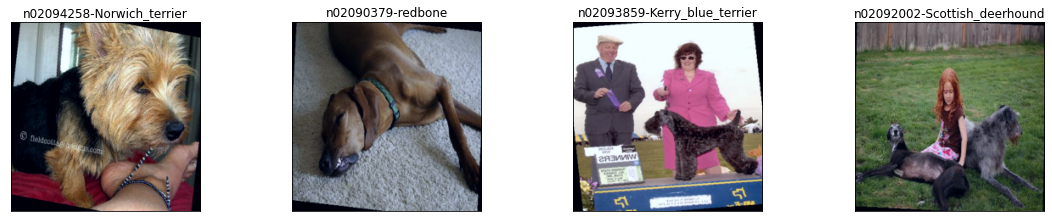

In [12]:
# Exibe algumas imagens do loader com correspondentes labels

meanm = np.mean(img_mean)
stdm = np.mean(img_std)        
recgn_utils.sample_img_show(train_loader, partial_class_names, meanm, stdm)

In [13]:
# Funcao que carrega modelo treinado com fine-tune, na Parte-1 

def load_model(checkpoint_path):
    chpt_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    chpt_out_features = 100
    # Recria model class
    model = models.resnet152(pretrained=True)
    classifier = nn.Sequential(nn.Linear(model.fc.in_features, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 256),
                                  nn.ReLU(),
                                  nn.Dropout(0.5),
                                  nn.Linear(256, chpt_out_features),
                                  nn.LogSoftmax(dim=1))
    model.fc = classifier
    model.load_state_dict(chpt_dict['model_state_dict'])
    return model

In [14]:
# Carrega modelo treinado com fine-tune, na Parte-1 
model = load_model(checkpoint_path)
print(model.fc)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=256, out_features=100, bias=True)
  (6): LogSoftmax(dim=1)
)


In [15]:
# Cria novo classificador

# Congela camadas para treinamento (feature extraction)
for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(nn.Linear(2048, 512), # model.fc.in_features = 2048
                              nn.ReLU(),
                              nn.Linear(512, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, num_classes_enroll),
                              nn.LogSoftmax(dim=1))
model.fc = classifier

# Define loss function (categorical cross-entropy)
# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
criterion = nn.NLLLoss()

# Define otimizador de treinamento e diferentes taxas de aprendizado ao longo da rede
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

if gpu_on:
    model.cuda()

Treinando Modelo | Epoca 1: 100%|██████████| 9/9 [00:00<00:00, 13.08it/s]
Validando Modelo | Epoca 1: 100%|██████████| 2/2 [00:00<00:00, 18.93it/s]


Epoca: 1 	Training Loss: 1.5953 	Validation Loss: 1.5742 	Acuracia: 40.0000%


Treinando Modelo | Epoca 2: 100%|██████████| 9/9 [00:00<00:00, 15.17it/s]
Validando Modelo | Epoca 2: 100%|██████████| 2/2 [00:00<00:00, 18.67it/s]


Epoca: 2 	Training Loss: 1.5630 	Validation Loss: 1.5710 	Acuracia: 50.0000%


Treinando Modelo | Epoca 3: 100%|██████████| 9/9 [00:00<00:00, 16.02it/s]
Validando Modelo | Epoca 3: 100%|██████████| 2/2 [00:00<00:00, 18.86it/s]


Epoca: 3 	Training Loss: 1.4902 	Validation Loss: 1.5529 	Acuracia: 60.0000%


Treinando Modelo | Epoca 4: 100%|██████████| 9/9 [00:00<00:00, 16.15it/s]
Validando Modelo | Epoca 4: 100%|██████████| 2/2 [00:00<00:00, 18.83it/s]


Epoca: 4 	Training Loss: 1.4222 	Validation Loss: 1.5779 	Acuracia: 60.0000%


Treinando Modelo | Epoca 5: 100%|██████████| 9/9 [00:00<00:00, 12.37it/s]
Validando Modelo | Epoca 5: 100%|██████████| 2/2 [00:00<00:00, 18.22it/s]


Epoca: 5 	Training Loss: 1.4101 	Validation Loss: 1.5670 	Acuracia: 60.0000%


Treinando Modelo | Epoca 6: 100%|██████████| 9/9 [00:00<00:00, 12.61it/s]
Validando Modelo | Epoca 6: 100%|██████████| 2/2 [00:00<00:00, 15.42it/s]


Epoca: 6 	Training Loss: 1.3320 	Validation Loss: 1.5188 	Acuracia: 60.0000%


Treinando Modelo | Epoca 7: 100%|██████████| 9/9 [00:00<00:00, 13.20it/s]
Validando Modelo | Epoca 7: 100%|██████████| 2/2 [00:00<00:00, 19.19it/s]


Epoca: 7 	Training Loss: 1.3083 	Validation Loss: 1.5168 	Acuracia: 60.0000%


Treinando Modelo | Epoca 8: 100%|██████████| 9/9 [00:00<00:00, 14.73it/s]
Validando Modelo | Epoca 8: 100%|██████████| 2/2 [00:00<00:00, 17.79it/s]


Epoca: 8 	Training Loss: 1.2541 	Validation Loss: 1.4511 	Acuracia: 60.0000%


Treinando Modelo | Epoca 9: 100%|██████████| 9/9 [00:00<00:00, 15.49it/s]
Validando Modelo | Epoca 9: 100%|██████████| 2/2 [00:00<00:00, 17.91it/s]


Epoca: 9 	Training Loss: 1.1922 	Validation Loss: 1.4934 	Acuracia: 60.0000%


Treinando Modelo | Epoca 10: 100%|██████████| 9/9 [00:00<00:00, 15.08it/s]
Validando Modelo | Epoca 10: 100%|██████████| 2/2 [00:00<00:00, 18.21it/s]


Epoca: 10 	Training Loss: 1.0938 	Validation Loss: 1.3905 	Acuracia: 60.0000%


Treinando Modelo | Epoca 11: 100%|██████████| 9/9 [00:00<00:00, 15.41it/s]
Validando Modelo | Epoca 11: 100%|██████████| 2/2 [00:00<00:00, 18.17it/s]


Epoca: 11 	Training Loss: 1.0558 	Validation Loss: 1.3845 	Acuracia: 70.0000%


Treinando Modelo | Epoca 12: 100%|██████████| 9/9 [00:00<00:00, 15.52it/s]
Validando Modelo | Epoca 12: 100%|██████████| 2/2 [00:00<00:00, 17.91it/s]


Epoca: 12 	Training Loss: 0.9138 	Validation Loss: 1.3116 	Acuracia: 60.0000%


Treinando Modelo | Epoca 13: 100%|██████████| 9/9 [00:00<00:00, 15.05it/s]
Validando Modelo | Epoca 13: 100%|██████████| 2/2 [00:00<00:00, 18.24it/s]


Epoca: 13 	Training Loss: 0.9514 	Validation Loss: 1.2647 	Acuracia: 80.0000%


Treinando Modelo | Epoca 14: 100%|██████████| 9/9 [00:00<00:00, 15.33it/s]
Validando Modelo | Epoca 14: 100%|██████████| 2/2 [00:00<00:00, 18.26it/s]


Epoca: 14 	Training Loss: 0.7789 	Validation Loss: 1.1592 	Acuracia: 80.0000%


Treinando Modelo | Epoca 15: 100%|██████████| 9/9 [00:00<00:00, 11.52it/s]
Validando Modelo | Epoca 15: 100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Epoca: 15 	Training Loss: 0.7203 	Validation Loss: 1.1364 	Acuracia: 80.0000%


Treinando Modelo | Epoca 16: 100%|██████████| 9/9 [00:00<00:00, 15.56it/s]
Validando Modelo | Epoca 16: 100%|██████████| 2/2 [00:00<00:00, 18.06it/s]


Epoca: 16 	Training Loss: 0.7071 	Validation Loss: 1.1216 	Acuracia: 80.0000%


Treinando Modelo | Epoca 17: 100%|██████████| 9/9 [00:00<00:00, 16.05it/s]
Validando Modelo | Epoca 17: 100%|██████████| 2/2 [00:00<00:00, 18.15it/s]


Epoca: 17 	Training Loss: 0.7473 	Validation Loss: 1.0200 	Acuracia: 80.0000%


Treinando Modelo | Epoca 18: 100%|██████████| 9/9 [00:00<00:00, 15.51it/s]
Validando Modelo | Epoca 18: 100%|██████████| 2/2 [00:00<00:00, 18.79it/s]


Epoca: 18 	Training Loss: 0.6269 	Validation Loss: 1.0905 	Acuracia: 80.0000%


Treinando Modelo | Epoca 19: 100%|██████████| 9/9 [00:00<00:00, 13.78it/s]
Validando Modelo | Epoca 19: 100%|██████████| 2/2 [00:00<00:00,  7.78it/s]


Epoca: 19 	Training Loss: 0.5104 	Validation Loss: 0.9163 	Acuracia: 80.0000%


Treinando Modelo | Epoca 20: 100%|██████████| 9/9 [00:00<00:00, 14.33it/s]
Validando Modelo | Epoca 20: 100%|██████████| 2/2 [00:00<00:00, 18.58it/s]


Epoca: 20 	Training Loss: 0.6211 	Validation Loss: 0.9267 	Acuracia: 80.0000%


Treinando Modelo | Epoca 21: 100%|██████████| 9/9 [00:00<00:00, 15.89it/s]
Validando Modelo | Epoca 21: 100%|██████████| 2/2 [00:00<00:00, 18.32it/s]


Epoca: 21 	Training Loss: 0.4891 	Validation Loss: 0.8463 	Acuracia: 80.0000%


Treinando Modelo | Epoca 22: 100%|██████████| 9/9 [00:00<00:00, 13.34it/s]
Validando Modelo | Epoca 22: 100%|██████████| 2/2 [00:00<00:00, 18.50it/s]


Epoca: 22 	Training Loss: 0.3660 	Validation Loss: 0.7682 	Acuracia: 80.0000%


Treinando Modelo | Epoca 23: 100%|██████████| 9/9 [00:00<00:00, 13.32it/s]
Validando Modelo | Epoca 23: 100%|██████████| 2/2 [00:00<00:00, 18.14it/s]


Epoca: 23 	Training Loss: 0.4495 	Validation Loss: 0.7442 	Acuracia: 80.0000%


Treinando Modelo | Epoca 24: 100%|██████████| 9/9 [00:00<00:00, 15.70it/s]
Validando Modelo | Epoca 24: 100%|██████████| 2/2 [00:00<00:00, 19.11it/s]


Epoca: 24 	Training Loss: 0.4122 	Validation Loss: 0.7495 	Acuracia: 80.0000%


Treinando Modelo | Epoca 25: 100%|██████████| 9/9 [00:00<00:00, 14.71it/s]
Validando Modelo | Epoca 25: 100%|██████████| 2/2 [00:00<00:00, 18.99it/s]


Epoca: 25 	Training Loss: 0.4127 	Validation Loss: 0.7775 	Acuracia: 80.0000%
Treinamento interrompido: tempo maximo atingido.


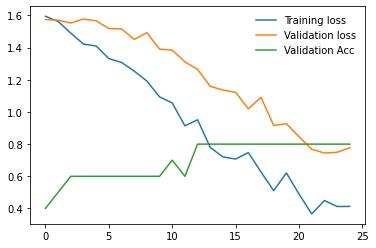

Tempo total (aprox.) = 55.36396813392639 segundos
Tempo medio por imagem (aprox.) = 0.08596889461789813 segundos


In [16]:
# Treina modelo 
start = time()

# Considera 3 condicoes de parada:
# 1) Valid loss medio crescente
# 2) Numero de epocas = num_epochs
# 3) Tempo maximo = total_img_enroll - 1

max_time = total_img_enroll - 1
model = recgn_utils.train_model(model, criterion, optimizer, loaders, num_epochs, 
                                gpu_on, max_time)

end = time()
print(f'Tempo total (aprox.) = {end - start} segundos') 
print(f'Tempo medio por imagem (aprox.) = {(end-start)/total_img} segundos') 

In [17]:
# Testa modelo treinado com loader de testes

prob_pass, prob_fail = recgn_utils.test_model(model, criterion, test_loader, gpu_on)

Testando Modelo:: 100%|██████████| 55/55 [00:29<00:00,  1.89it/s]

Test Loss: 0.515311
Acuracia do Teste: 83% (226/272)


Text(0.5, 1.0, 'Max outputs')

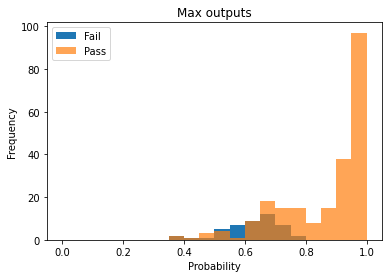

In [18]:
# Plota distribuição de probabilidades nos cassos de pass e fail do teste   

plt.hist(prob_fail, bins = np.arange(0,1.05,0.05)) 
plt.hist(prob_pass, bins = np.arange(0,1.05,0.05), alpha = 0.7) 
labels= ["Fail","Pass"]
plt.legend(labels)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Max outputs')

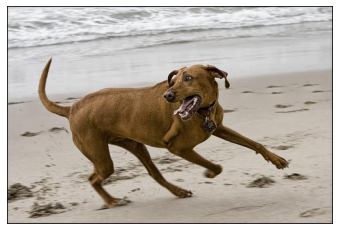

Foto selecionada aleatoriamente em:./rcgn_sample/test/n02087394-Rhodesian_ridgeback/n02087394_4603.jpg
Probabilidade de 67.20% de ser um n02087394-Rhodesian_ridgeback


In [19]:
# Seleciona uma foto aleatoria e testa o modelo

enroll_dir = './rcgn_sample/test/*/*'
enroll_data = np.array(glob(enroll_dir))
img_path = np.random.choice(enroll_data, 1)[0]
recgn_utils.imshow(img_path)
print(f'Foto selecionada aleatoriamente em:{img_path}')
pred_breed, pred_prob = recgn_utils.predict_breed_dog(model, partial_class_names, img_mean, img_std, img_path, gpu_on)
print(f'Probabilidade de {pred_prob*100:.2f}% de ser um {pred_breed}')